In [1]:
#Import the libraries that we need
import numpy as np
import torch
import torch.nn.functional as F
import torchvision
import timm
import matplotlib.pyplot as plt

from torch import nn
from torch import optim
from tqdm import tqdm # This is optional but useful
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms as T

C:\Users\slocu\anaconda3\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: Could not find module 'C:\Users\slocu\anaconda3\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


In [2]:
class SimpleNet(nn.Module):
    def __init__(self,
                 ninputs=3*32*32,
                 nhidden=512,
                 nout=10,
                ):
        super().__init__()
        self.net = nn.Linear(ninputs, nout, bias=False)       
        
    def forward(self, x):
        b, c, h, w = x.shape
        x = x.view(b, -1)
        x = self.net(x)
        return x

In [3]:
class LogisticNet(nn.Module):
    def __init__(self,
                 ninputs=3*32*32,
                 nhidden=512,
                 nout=10,
                ):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(ninputs, nhidden, bias=True),
            nn.ReLU(),
            nn.Linear(nhidden, nhidden),
            nn.ReLU(),
            nn.Linear(nhidden, nhidden),
            nn.ReLU(),
            nn.Linear(nhidden, nout, bias=True),
            nn.ReLU(),
        )

    def forward(self, x):
        b, c, h, w = x.shape
        x = x.view(b, -1)
        x = torch.sigmoid(self.net(x))
        return x

In [4]:
class SoftMaxNet(nn.Module):
    def __init__(self,
                 ninputs=3*32*32,
                 nhidden=512,
                 nout=10,
                ):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(ninputs, nhidden, bias=False),
            nn.ReLU(),
            nn.Linear(nhidden, nhidden),
            nn.ReLU(),
            nn.Linear(nhidden, nout, bias=False),
            nn.ReLU(),
        )

    def forward(self, x):
        b, c, h, w = x.shape
        x = x.view(b, -1)
        x = F.softmax(self.net(x), dim=1)
        return x

In [5]:
class LinearNet(nn.Module):
    def __init__(self,
                 ninputs=3*32*32,
                 nhidden=512,
                 nout=10,
                ):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(ninputs, nhidden, bias=True),
            nn.ReLU(),
            nn.Linear(nhidden, nhidden),
            nn.ReLU(),
            nn.Linear(nhidden, nout, bias=True),
            nn.ReLU(),
        )

    def forward(self, x):
        b, c, h, w = x.shape
        x = x.view(b, -1)
        x = self.net(x)
        return x

In [9]:
class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, 1, padding=1)
        conv1.shape()
        self.conv2 = nn.Conv2d(16, 32, 3, 1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, 1, padding=1)
        self.fc1 = nn.Linear(4*4*64, 500)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(500, 10)
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*64)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.fc2(x)
        return x

In [10]:
# Let's get the right torch device (preference of GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Let's set up some parameters
learning_rate=0.001
nepochs = 10
ninputs=3*32*32
nhidden=1024
nout=10

model = LinearNet(ninputs=ninputs, nhidden=nhidden, nout=nout).to(device)
#model = LeNet().to(device)
#model = torchvision.models.vgg19(pretrained=True)
#model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)

print(model)

# We need an optimizer that tells us what form of gradient descent to do
optimizer = torch.optim.Adam(model.parameters(), learning_rate)

# We also need a loss function
LossFunction = nn.CrossEntropyLoss()

batch_size = 200

cifar_dataset = datasets.CIFAR10(root='./', # here
                               train=True, # train split
                               download=True, # we want to get the data
                               transform=T.ToTensor(), # put it into tensor format
                              )
train_data = DataLoader(cifar_dataset,
                        batch_size=batch_size,
                        )
# This is default on but let's just be pedantic
model.train()
loss_history = []
loss = torch.Tensor([0])
for epoch in tqdm(range(nepochs),
                  desc=f"Epoch",
                  unit="epoch",
                  disable=False):
    for (data, label) in tqdm(train_data,
                              desc="iteration",
                              unit="%",
                              disable=True):
        optimizer.zero_grad(set_to_none=True) # Here we clear the gradients
        
        # We need to make sure the tensors are on the same device as our model
        data = data.to(device)
        label = label.to(device)
        out = model(data)
        
        loss = LossFunction(out, label)
        
        loss.backward() # This function calculates all our gradients
        optimizer.step() # This function does our gradient descent with those gradients
        loss_history.append(loss.item())
    print(f"Epoch {epoch}: loss: {loss.item()}")


LinearNet(
  (net): Sequential(
    (0): Linear(in_features=3072, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=1024, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1024, out_features=10, bias=True)
    (5): ReLU()
  )
)
Files already downloaded and verified


Epoch:   0%|                                                                                 | 0/10 [00:09<?, ?epoch/s]


KeyboardInterrupt: 

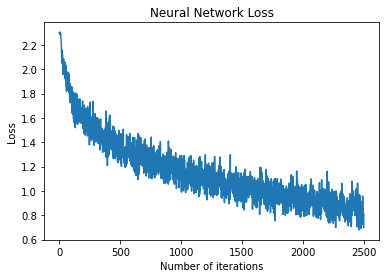

Files already downloaded and verified
Total accuracy = 67.99%


In [28]:
# Note that we are not plotting loss per epoch but per iteration
plt.plot(loss_history)
plt.title("Neural Network Loss")
plt.xlabel("Number of iterations")
plt.ylabel("Loss")
plt.show()

# We need to do the test data now
cifar_test_dataset = datasets.CIFAR10(root='./', train=False, download=True, transform=T.ToTensor(),)
test_data = DataLoader(cifar_test_dataset, batch_size=batch_size,)

model.eval()
accuracy = 0
for (data, label) in test_data:
    data = data.to(device)
    label = label.to(device)
    out = model(data)
    answers = out.max(dim=1)[1]
    accuracy += (answers == label).sum()
print(f"Total accuracy = {accuracy / len(cifar_test_dataset)*100:.2f}%")